In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from statsmodels.tsa.seasonal import STL

In [2]:
#return temporal influence ranges of anomalies
def temporalanomaly(timeseries,unitsize):
    #abnormal time slots
    timeslots=[]
    l=len(timeseries)
    Q1=np.percentile(timeseries,25)
    Q3=np.percentile(timeseries,75)
    IQR=Q3-Q1
    upper=Q3+1.5*IQR
    lower=Q1-1.5*IQR
    for i in range(l):
        if(timeseries[i]>upper or timeseries[i]<lower):
            timeslots.append(i)
    
    #temporal influence range
    temporalrange=[]
    start=-1
    end=-1
    timeslotsnum=len(timeslots)
    #only 1 abnormal time slot
    if(timeslotsnum==1):
        tmp=[timeslots[0]*unitsize,(timeslots[0]+1)*unitsize]
        temporalrange.append(tmp)
        return np.array(temporalrange)
    #other situations
    for i in range(timeslotsnum):
        if(i==0):
            start=timeslots[i]
            end=timeslots[i]+1
            continue
        if(i!=timeslotsnum-1):
            if(timeslots[i]==end):
                end=timeslots[i]+1
                continue
            if(timeslots[i]!=end):
                tmp=[start*unitsize,end*unitsize]
                temporalrange.append(tmp)
                start=timeslots[i]
                end=timeslots[i]+1
                continue
        if(i==timeslotsnum-1):
            if(timeslots[i]==end):
                end=timeslots[i]+1
                tmp=[start*unitsize,end*unitsize]
                temporalrange.append(tmp)
                continue
            if(timeslots[i]!=end):
                tmp=[start*unitsize,end*unitsize]
                temporalrange.append(tmp)
                start=timeslots[i]
                end=timeslots[i]+1
                tmp=[start*unitsize,end*unitsize]
                temporalrange.append(tmp)
        
    return np.array(temporalrange)

In [3]:
#simulation experiment
simulationnum=500

#normal activity parameters
days=12
sigma=4
num=1000

#anomaly parameters
anomalynum=3
rnum=[50,200,800]
rsigma=[0.25,1,4]

#four results
tt_1=np.zeros(anomalynum) # scale 1
tt_2=np.zeros(anomalynum) # scale 2
tt_3=np.zeros(anomalynum) # scale 3
mtt=np.zeros(anomalynum) # multi-scale

#multi
#tt,ft,total
result1=np.zeros(3)
result2=np.zeros(3)
result3=np.zeros(3)


for k in range(simulationnum):
    totaldata=np.array([])
    
    #generate normal activities
    for i in range(days):
        mu=12+24*i
        normal_data=np.random.normal(mu,sigma,num)
        totaldata=np.append(totaldata,normal_data)
        
    #generate anomalies
    start_t=0
    end_t=24*days
    anomalytime=[]
    anomaly=np.array([])
    for i in range(anomalynum):
        rmu=np.random.rand()*end_t # real anomaly time
        anomalytime.append(rmu)
        anomaly_data=np.random.normal(rmu,rsigma[i],rnum[i])
        totaldata=np.append(totaldata,anomaly_data) # normal activities + anomalies
        anomaly=np.append(anomaly,anomaly_data)
    
    #time-series organization
    unitsize_1=0.25 # 15 minutes
    unitsize_2=1 # 1 hour
    unitsize_3=4 # 4 hours
    volumes_1=np.zeros(int(end_t/unitsize_1))
    volumes_2=np.zeros(int(end_t/unitsize_2))
    volumes_3=np.zeros(int(end_t/unitsize_3))
    
    #volume
    for i in totaldata:
        index_1=int(i/unitsize_1)
        index_2=int(i/unitsize_2)
        index_3=int(i/unitsize_3)
        if(index_1>=0 and index_1<int(end_t/unitsize_1)):
            volumes_1[index_1]+=1
        if(index_2>=0 and index_2<int(end_t/unitsize_2)):
            volumes_2[index_2]+=1
        if(index_3>=0 and index_3<int(end_t/unitsize_3)):
            volumes_3[index_3]+=1
            
    #anomaly detection at three temporal scales
    decomp1 = STL(np.array(volumes_1), period=96).fit() # period=24/0.25=96
    decomp2 = STL(np.array(volumes_2), period=24).fit() # period=24/1=24
    decomp3 = STL(np.array(volumes_3), period=6).fit() # period=24/4=6
    
    anomaly_1=temporalanomaly(np.array(decomp1.resid),unitsize_1)
    anomaly_2=temporalanomaly(np.array(decomp2.resid),unitsize_2)
    anomaly_3=temporalanomaly(np.array(decomp3.resid),unitsize_3)

    
    #comparison
    #three anomalies
    for i in range(anomalynum):
        tag=0
        for j in anomaly_1:
            if(anomalytime[i]>=j[0] and anomalytime[i]<j[1]):
                tt_1[i]+=1
                tag=1
                continue
        for j in anomaly_2:
            if(anomalytime[i]>=j[0] and anomalytime[i]<j[1]):
                tt_2[i]+=1
                tag=1
                continue
        for j in anomaly_3:
            if(anomalytime[i]>=j[0] and anomalytime[i]<j[1]):
                tt_3[i]+=1
                tag=1
                continue
        if(tag==1):
            mtt[i]+=1

#result            
print("Scale 1:",tt_1*1.0/(simulationnum))
print("Scale 2:",tt_2*1.0/(simulationnum))   
print("Scale 3:",tt_3*1.0/(simulationnum))
print("Multi-scale:",mtt*1.0/(simulationnum))


Scale 1: [0.92  0.896 0.656]
Scale 2: [0.824 0.986 0.936]
Scale 3: [0.266 0.922 0.988]
Multi-scale: [0.948 0.996 0.99 ]


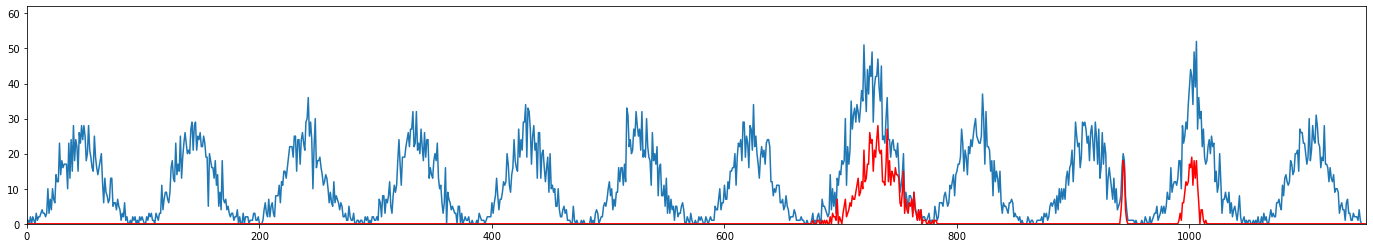

In [4]:
#visualization sample
unitsize=0.25
observed_timeseries=np.zeros(int(end_t/unitsize))
anomaly_timeseries=np.zeros(int(end_t/unitsize))
for i in totaldata:
    intpart=int(i/unitsize)
    if(intpart>=0 and intpart<int(end_t/unitsize)):
        observed_timeseries[intpart]+=1
for i in anomaly:
    intpart=int(i/unitsize)
    if(intpart>=0 and intpart<int(end_t/unitsize)):
        anomaly_timeseries[intpart]+=1
plt.figure(figsize = (24, 4))
plt.xlim(0, int(end_t/unitsize))
plt.ylim(0, max(observed_timeseries)+10)
index=np.arange(0,int(end_t/unitsize))
plt.plot(index,observed_timeseries)
plt.plot(index,anomaly_timeseries,color='r')
plt.show()